# Reevaluate RL

In [1]:
import sys; sys.path.append('../src')
from utils.data import load_data, get_history, top_markets

TIMEFRAME = '1m' #['1h', '1d']
QUOTE     = 'USDT'
LIMIT     = 2000
N         = 10

## Pull in data of interest

In [17]:
markets = top_markets(quote=QUOTE)[:N]
history = get_history(markets, timeframe=TIMEFRAME, limit=LIMIT)
history.tail()

,BTC/USDT,ETH/USDT,XRP/USDT,BCH/USDT,BSV/USDT,LTC/USDT,EOS/USDT,ADA/USDT,XTZ/USDT,LINK/USDT
time,,,,,,,,,,
2020-05-31 06:32:00,9562.69,237.68,0.20321,246.26,196.9372,46.47,2.6984,0.079330,2.8742,4.0785
2020-05-31 06:33:00,9564.98,237.91,0.20328,246.33,197.0050,46.46,2.6986,0.079415,2.8735,4.0785
2020-05-31 06:34:00,9560.92,237.86,0.20331,246.31,196.9709,46.46,2.7000,0.079429,2.8738,4.0781
2020-05-31 06:35:00,9563.13,238.00,0.20352,246.37,197.0192,46.46,2.7013,0.079555,2.8688,4.0774
2020-05-31 06:36:00,9562.65,237.99,0.20357,246.40,197.1625,46.50,2.7013,0.079565,2.8680,4.0772


In [25]:
from st.cointegration import find_cointegrated_pairs
scores, pvalues, pairs = find_cointegrated_pairs(history)

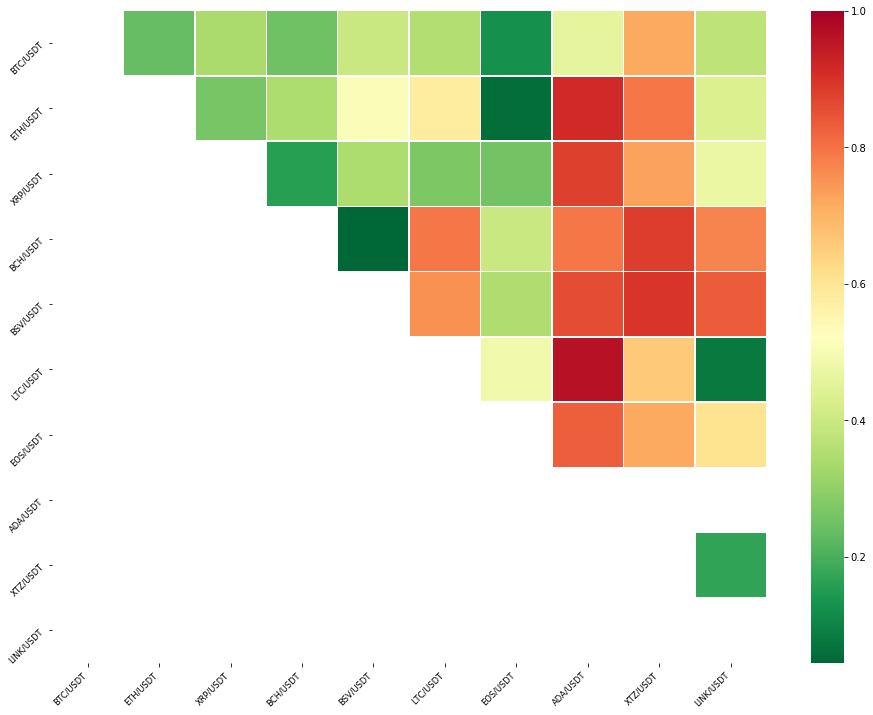

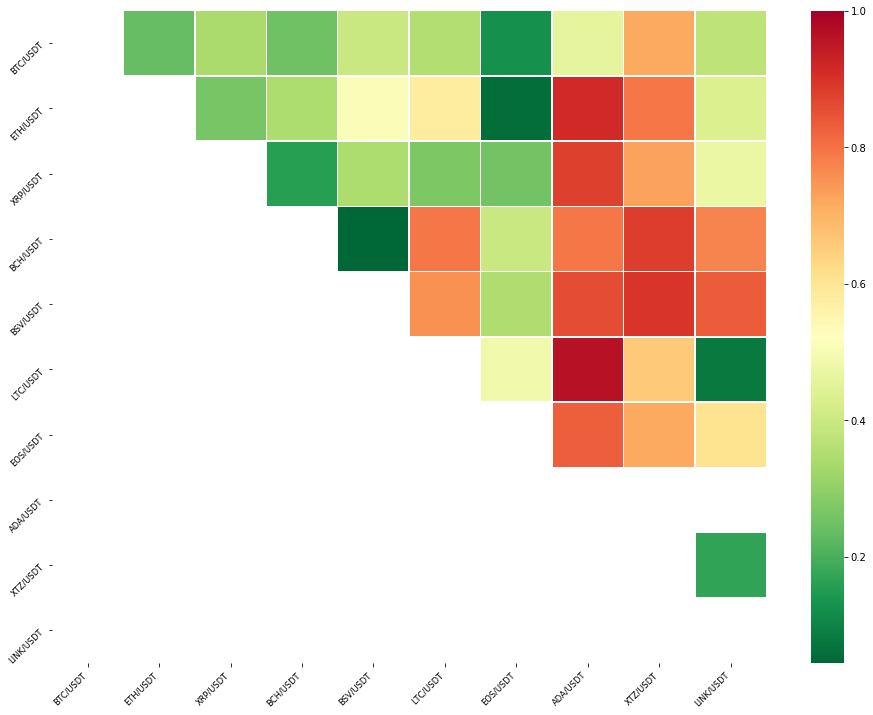

In [34]:
from IPython.core.display import HTML

def row(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )


def plot_heatmap(pvalues, cutoff=0.98):
    # plot heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig,ax = plt.subplots(1,1,figsize=[16,12])
    g=sns.heatmap(pvalues, ax=ax, cmap='RdYlGn_r', mask = (pvalues >= cutoff), linewidths=.5, 
                    xticklabels=markets, yticklabels=markets)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='small')
    g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right', fontsize='small')
    return fig

def data_df(pairs):
    import pandas as pd
    import seaborn as sns
    data={'market1': [k[0] for k in pairs.keys()],
          'market2': [k[1] for k in pairs.keys()],
          'p-value': [v[1] for v in pairs.values()]}

    cm  = sns.light_palette("green", as_cmap=True)
    df  = pd.DataFrame(data).sort_values('p-value').reset_index(drop=True)
    df_ = df.copy()
    df  = df.style.background_gradient(subset=['p-value'], cmap=cm)
    df_['pair'] = df_["market1"].map(str) + ' -- ' + df_["market2"]
    return df


def fit_ols(data, market1, market2):
    import statsmodels.api as sm
    import pandas as pd
    x1=data[market1].values
    x2=data[market2].values
    r=sm.OLS(x1,x2).fit().params[0]
    return pd.DataFrame({'x1':x1, 'r*x2':r*x2, 'z':x1 - r*x2}, index=data.index)
    

def plot_trajectory(df_x):
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig,axs = plt.subplots(2, 1, figsize=[16,8])
    a=sns.lineplot(data=df_x[['x1', 'r*x2']], ax=axs[0])
    b=sns.lineplot(data=df_x[['z']], ax=axs[1], palette=['green'])
    a.figure.canvas.draw(); a.set_xticklabels(a.get_xticklabels(), fontsize='x-small')
    b.figure.canvas.draw(); b.set_xticklabels(b.get_xticklabels(), fontsize='x-small')
    plt.tight_layout()
    
plot_heatmap(pvalues)

,x1,r*x2,z
time,,,
2020-05-29 21:17:00,9391.21,8952.198179,439.011821
2020-05-29 21:18:00,9390.74,8951.382378,439.357622
2020-05-29 21:19:00,9390.37,8951.382378,438.987622
2020-05-29 21:20:00,9406.99,8959.948294,447.041706
2020-05-29 21:21:00,9406.02,8961.987798,444.032202
...,...,...,...
2020-05-31 06:32:00,9562.69,9694.985480,-132.295480
2020-05-31 06:33:00,9564.98,9704.367198,-139.387198
2020-05-31 06:34:00,9560.92,9702.327694,-141.407694


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


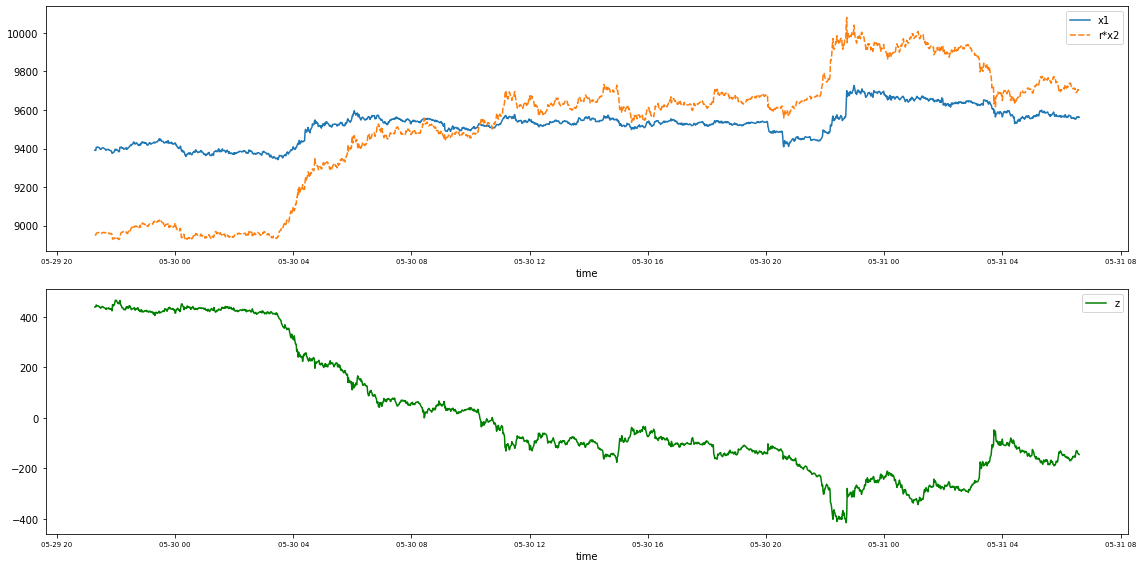

In [35]:
display(row([results, data_df(pairs)]))
plot_trajectory(results)

---

## RL agent

In [39]:
from rl.rl_agent import RLAgent                # import agent
import dgp.stationary_dgp as sdgp              # stationary data generating process
import dgp.timevarying_dgp as nsdgp            # non-stationary data generating process
from rl.simulation import run_simulation       # simulation code

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl

In [40]:
# hyperparameters
N = 2000
REWARD_HORIZON = 100
DISCOUNT_DECAY = 0.95

NUM_TRAINING_ITERATIONS = 100
NUM_TEST_ITERATIONS     = 100

CHECKPOINT = False

In [60]:
%load_ext autoreload
%autoreload 2

In [68]:
### Compare to agent trained on historical data only

def train_agent(nsdgp, single_realisation=True, real_spread=True):
    """
    Train agent using chosen DGP (either stationary or non-stationary), on either a single realisation, or
    a different realisation for every loop.
    """
    agent = RLAgent(2, 3) # state size = 2, action size = 3
    training_pnls = []
    DELTA = 10
    for j in tqdm(range(NUM_TRAINING_ITERATIONS)):
        x,y = nsdgp.generateDGP()
        training_pnl = run_simulation(x, y, agent, True, real_spread) 
        training_pnls.append(training_pnl)
        if j % DELTA == 0:
            agent.replay()
            pct_progress = (float(j) / float(NUM_TRAINING_ITERATIONS)) * 100.0
            if j == 0:
                print("pct_progress = {} %%".format(pct_progress))
            else:
                print("pct_progress = {} %% (current average P&L is {})".format(pct_progress,
                                                                                np.mean(training_pnls[-DELTA:])))
                
    # save model
    model = '../models/agent_{}.pkl'.format(experiment.split(':')[0].replace(' ', '_').lower())
    with open(model, 'wb') as f:
        pkl.dump((agent,training_pnls), f)  

In [92]:
from dgp.dgp import NonStationary
nsdgp = NonStationary(N=2000, sigmaX=5, sigmaEta=5, theta=0.01, muX=50, mu=100, jump=20, cauchy=0.01)

In [69]:
# Experiment I
experiment = '1'
train_agent(nsdgp, single_realisation=True, real_spread=True)


  1%|          | 1/100 [00:00<00:38,  2.58it/s]

pct_progress = 0.0 %%



 11%|█         | 11/100 [00:20<02:47,  1.89s/it]

pct_progress = 10.0 %% (current average P&L is [])



 21%|██        | 21/100 [00:41<02:55,  2.22s/it]

pct_progress = 20.0 %% (current average P&L is [])



 31%|███       | 31/100 [01:05<02:42,  2.35s/it]

pct_progress = 30.0 %% (current average P&L is [])



 41%|████      | 41/100 [01:26<02:06,  2.14s/it]

pct_progress = 40.0 %% (current average P&L is [])



 51%|█████     | 51/100 [01:49<01:53,  2.32s/it]

pct_progress = 50.0 %% (current average P&L is [])



 61%|██████    | 61/100 [02:12<01:34,  2.43s/it]

pct_progress = 60.0 %% (current average P&L is [])



 71%|███████   | 71/100 [02:35<01:10,  2.42s/it]

pct_progress = 70.0 %% (current average P&L is [])



 81%|████████  | 81/100 [02:58<00:46,  2.44s/it]

pct_progress = 80.0 %% (current average P&L is [])



 91%|█████████ | 91/100 [03:22<00:21,  2.38s/it]

pct_progress = 90.0 %% (current average P&L is [])



100%|██████████| 100/100 [03:43<00:00,  2.23s/it]


In [93]:
nsdgp.generateDGP()

(array([48.30553521, 46.8382217 , 41.08045681, ...,  5.05549107,
         2.22849124, -3.58038634]),
 array([148.76526498, 152.47347702, 148.05603439, ...,  96.26993428,
         95.26663444,  86.33768337]))

In [94]:
def test_agent(dgp, experiment, real_spread=True):
    """
    Load agent from saved model, and evaluate from NUM test iterations, with a new realisation each time.
    """
    model = '../models/agent_{}.pkl'.format(experiment.split(':')[0].replace(' ', '_').lower())
    with open(model, 'rb') as f:
        agent,training_pnls = pkl.load(f)
            
    in_samplePnLs  = []; out_samplePnLs = []; agent.epsilon  = 0.  # We don't want to explore at test time

    # 3. test the agent on a series of stationary trajectories, show that it generalizes
    print("Testing the agent...")
    for j in tqdm(range(NUM_TEST_ITERATIONS)):
        x_test, y_test = dgp.generateDGP(N)                    # generate new artificial test data from the same process
        out_samplePnL,_ = run_simulation(x_test, y_test, agent, False, real_spread) 
        out_samplePnLs.append(out_samplePnL)                    # append results

    return training_pnls, out_samplePnLs

training_pnls, out_samplePnLs = test_agent(nsdgp, experiment=experiment)




  0%|          | 0/100 [00:00<?, ?it/s]

Testing the agent...





  1%|          | 1/100 [00:00<01:26,  1.14it/s]


  2%|▏         | 2/100 [00:01<01:26,  1.13it/s]


  3%|▎         | 3/100 [00:02<01:28,  1.10it/s]


  4%|▍         | 4/100 [00:03<01:35,  1.00it/s]


  5%|▌         | 5/100 [00:05<01:38,  1.03s/it]


  6%|▌         | 6/100 [00:06<01:38,  1.05s/it]


  7%|▋         | 7/100 [00:07<01:33,  1.00s/it]


  8%|▊         | 8/100 [00:07<01:29,  1.03it/s]


  9%|▉         | 9/100 [00:08<01:26,  1.05it/s]


 10%|█         | 10/100 [00:09<01:23,  1.07it/s]


 11%|█         | 11/100 [00:10<01:22,  1.08it/s]


 12%|█▏        | 12/100 [00:11<01:20,  1.09it/s]


 13%|█▎        | 13/100 [00:12<01:19,  1.10it/s]


 14%|█▍        | 14/100 [00:13<01:17,  1.11it/s]


 15%|█▌        | 15/100 [00:14<01:16,  1.11it/s]


 16%|█▌        | 16/100 [00:15<01:15,  1.12it/s]


 17%|█▋        | 17/100 [00:16<01:15,  1.10it/s]


 18%|█▊        | 18/100 [00:16<01:14,  1.10it/s]


 19%|█▉        | 19/100 [00:17<01:13,  1.10it/s]


 20%|██        | 20/100 [00:19<01:19,

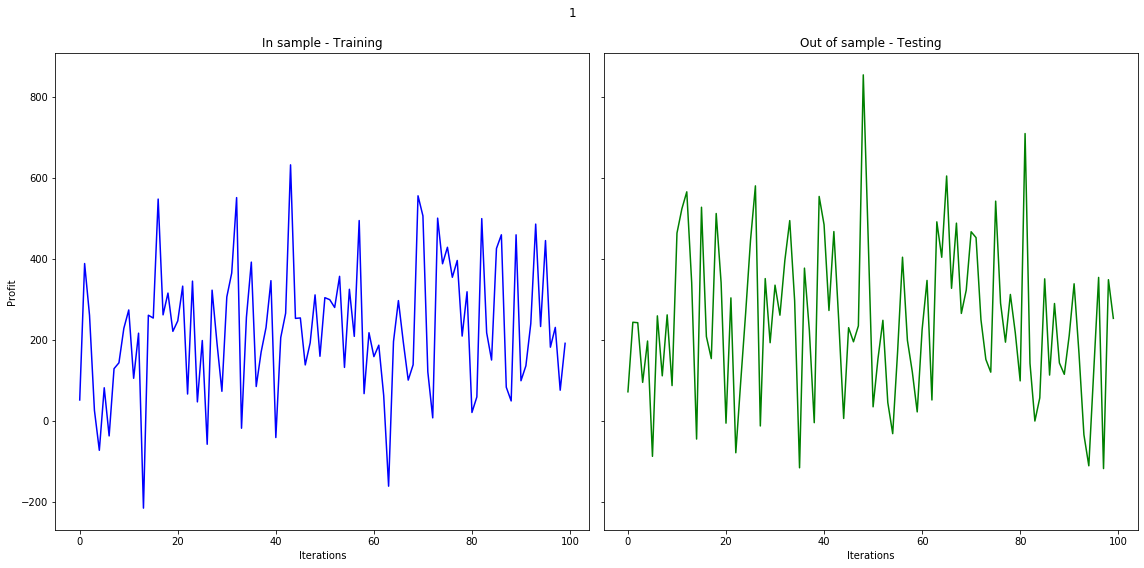

In [95]:
def plot_results(training_pnls, test_pnls, title, savefig=True):
    """
    Plot training and test profit and loss.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (16,8))

    _=ax1.plot(training_pnls, color='blue');    ax1.set_title("In sample - Training"); 
    ax1.set_xlabel("Iterations");               ax1.set_ylabel("Profit")
    _=ax2.plot(test_pnls, color='green');       ax2.set_title("Out of sample - Testing"); 
    ax2.set_xlabel("Iterations");

    fig.suptitle(title);
    fig.tight_layout(); fig.subplots_adjust(top=0.9);
    
    if savefig:
        fig.savefig('../figures/' + title.replace(' ', '_').lower() + '.png')
        
plot_results([t[0] for t in training_pnls], out_samplePnLs, title=experiment)

---
---